In [77]:
import pandas as pd
from cri98tj.distancers.Euclidean_distancer import Euclidean_distancer
from cri98tj.partitioners.Geohash_partitioner import Geohash_partitioner
from cri98tj.selectors.OPTICS_selector import OPTICS_selector
from cri98tj.selectors.RandomInformationGain_selector import RandomInformationGain_selector
from cri98tj.selectors.Random_selector import Random_selector
from cri98tj.selectors.RandomOrderline_selector import RandomOrderline_selector
from cri98tj.prebuilded_transformers.GeohashXmensEuclideian_prebuild import gxe_prebuild
from cri98tj.TrajectoryTransformer import TrajectoryTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [38]:
df = pd.read_csv("data/prepared_carORbus.zip")

df

,track_id,car_or_bus,time,latitude,longitude
0,1,1,2014-09-13 07:24:32,-10.939341,-37.062742
1,1,1,2014-09-13 07:24:37,-10.939341,-37.062742
2,1,1,2014-09-13 07:24:42,-10.939324,-37.062765
3,1,1,2014-09-13 07:24:47,-10.939211,-37.062843
4,1,1,2014-09-13 07:24:53,-10.938939,-37.062879
...,...,...,...,...,...
18102,38092,2,2016-01-19 13:01:01,-10.923722,-37.106579
18103,38092,2,2016-01-19 13:01:12,-10.923704,-37.106693
18104,38092,2,2016-01-19 13:01:24,-10.923715,-37.106688
18105,38092,2,2016-01-19 13:01:36,-10.923715,-37.106688


In [108]:
from datetime import datetime

df.time = df.time.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timestamp())

df

TypeError: strptime() argument 1 must be str, not float

In [119]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(df[["latitude", "longitude", "time"]].values, df["car_or_bus"].values, test_size=.3, stratify=df["car_or_bus"].values, random_state=3)

clf =  tree.DecisionTreeClassifier(max_depth=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.96      0.88      4204
           2       0.65      0.28      0.39      1229

    accuracy                           0.80      5433
   macro avg       0.74      0.62      0.64      5433
weighted avg       0.78      0.80      0.77      5433



[Text(0.5, 0.75, 'longitude <= -37.087\ngini = 0.35\nsamples = 12674\nvalue = [9807, 2867]'),
 Text(0.25, 0.25, 'gini = 0.442\nsamples = 1285\nvalue = [424, 861]'),
 Text(0.75, 0.25, 'gini = 0.29\nsamples = 11389\nvalue = [9383, 2006]')]

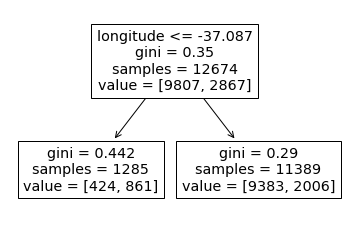

In [120]:
tree.plot_tree(clf, feature_names=["latitude", "longitude"])

In [129]:
clf =  tree.DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.98      0.96      4204
           2       0.92      0.76      0.84      1229

    accuracy                           0.93      5433
   macro avg       0.93      0.87      0.90      5433
weighted avg       0.93      0.93      0.93      5433



[Text(0.39680232558139533, 0.9285714285714286, 'longitude <= -37.087\ngini = 0.35\nsamples = 12674\nvalue = [9807, 2867]'),
 Text(0.12790697674418605, 0.7857142857142857, 'latitude <= -10.931\ngini = 0.442\nsamples = 1285\nvalue = [424, 861]'),
 Text(0.06976744186046512, 0.6428571428571429, 'time <= 1418773248.0\ngini = 0.008\nsamples = 243\nvalue = [242, 1]'),
 Text(0.046511627906976744, 0.5, 'longitude <= -37.323\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.023255813953488372, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.06976744186046512, 0.35714285714285715, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.09302325581395349, 0.5, 'gini = 0.0\nsamples = 240\nvalue = [240, 0]'),
 Text(0.18604651162790697, 0.6428571428571429, 'time <= 1431673728.0\ngini = 0.288\nsamples = 1042\nvalue = [182, 860]'),
 Text(0.13953488372093023, 0.5, 'latitude <= -10.91\ngini = 0.039\nsamples = 746\nvalue = [15, 731]'),
 Text(0.11627906976744186, 0.3571428571428571

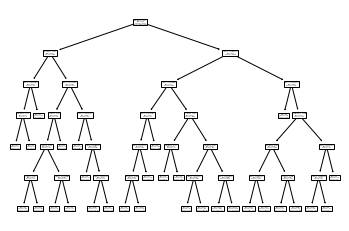

In [130]:
tree.plot_tree(clf, feature_names=["latitude", "longitude", "time"])

In [80]:
tid_train, tid_test, _, _ = train_test_split(df.groupby(by=["track_id"]).max().reset_index()["track_id"], df.groupby(by=["track_id"]).max().reset_index()["car_or_bus"], test_size=.3,
                                             stratify=df.groupby(by=["track_id"]).max().reset_index()["car_or_bus"],
                                             random_state=3)

In [100]:
partitioner = Geohash_partitioner(precision=8)

part = partitioner.fit_transform(df[df.track_id.isin(tid_train)].values)

#selector = OPTICS_selector(n_jobs=20, fillna_value=0.0)
#selector = Random_selector(movelets_per_class=8)
#selector = XMeans_selector(kmax=20, fillna_value=0.0)
selector = RandomOrderline_selector(top_k=10, movelets_per_class=None, trajectories_for_orderline=None, n_jobs=20)
#selector = RandomInformationGain_selector(top_k=100, movelets_per_class=None, trajectories_for_orderline=None, n_jobs=20)

shapelets = selector.fit_transform(part)

distancer = Euclidean_distancer(n_jobs=20)

df_distances = pd.DataFrame(distancer.fit_transform( (df.values, shapelets) ))

Encoding 11913 points with precision 8


  0%|          | 0/11913 [00:00<?, ?it/s]

Retrieving partition boundaries


  0%|          | 0/11913 [00:00<?, ?it/s]

Normalizing the sub-trajectories
Cutting sub-trajectories length at 65.39999999999964
Pivoting tables
Cutting sub-trajectories length at 368.0
Pivoting tables


C:\Users\cri98\Documents\GitHub\cri98tj\cri98tj\selectors\selector_utils.py:21: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_pivot = df_pivot.merge(df.groupby(['tid'])['class'].max().reset_index(), on=["tid"])


Computing scores


C:\Users\cri98\Documents\GitHub\cri98tj\cri98tj\selectors\selector_utils.py:21: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_pivot = df_pivot.merge(df.groupby(['tid'])['class'].max().reset_index(), on=["tid"])


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

0.	 score=0.0
1.	 score=0.0
2.	 score=0.0
3.	 score=0.0
4.	 score=0.0
5.	 score=0.0
6.	 score=0.0
7.	 score=0.0
8.	 score=0.0
9.	 score=0.0
Pivoting tables


C:\Users\cri98\Documents\GitHub\cri98tj\cri98tj\selectors\selector_utils.py:21: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_pivot = df_pivot.merge(df.groupby(['tid'])['class'].max().reset_index(), on=["tid"])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [101]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=None, random_state=0, n_jobs=-1)

dist_np_df = pd.DataFrame(df_distances.values)
X = dist_np_df.drop(columns=[0]).values
y = dist_np_df[0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=3)

clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [102]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.69      0.85      0.76        26
         2.0       0.76      0.57      0.65        23

    accuracy                           0.71        49
   macro avg       0.73      0.71      0.70        49
weighted avg       0.72      0.71      0.71        49



### Code used to prepare the dataset

In [20]:
trackspoints_df = pd.read_csv("data/go_track_trackspoints.csv")
tracks_df = pd.read_csv("data/go_track_tracks.csv").drop(columns=["time"])

In [21]:
tracks_df.head()

,id,id_android,speed,distance,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,0,19.210586,2.652,3,0,0,1,NaN
1,2,0,30.848229,5.290,3,0,0,1,NaN
2,3,1,13.560101,0.918,3,0,0,2,NaN
3,4,1,19.766679,7.700,3,0,0,2,NaN
4,8,0,25.807401,3.995,2,0,0,1,NaN


In [26]:
trackspoints_df

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53
...,...,...,...,...,...
18102,19565,-10.923722,-37.106579,38092,2016-01-19 13:01:01
18103,19566,-10.923704,-37.106693,38092,2016-01-19 13:01:12
18104,19567,-10.923715,-37.106688,38092,2016-01-19 13:01:24
18105,19568,-10.923715,-37.106688,38092,2016-01-19 13:01:36


In [32]:
df = tracks_df.merge(trackspoints_df, left_on=["id"], right_on=["track_id"])

df

,id_x,id_android,speed,distance,rating,rating_bus,rating_weather,car_or_bus,linha,id_y,latitude,longitude,track_id,time
0,1,0,19.210586,2.652,3,0,0,1,NaN,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,1,0,19.210586,2.652,3,0,0,1,NaN,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,1,0,19.210586,2.652,3,0,0,1,NaN,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,1,0,19.210586,2.652,3,0,0,1,NaN,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,1,0,19.210586,2.652,3,0,0,1,NaN,5,-10.938939,-37.062879,1,2014-09-13 07:24:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18102,38092,27,1.372998,0.023,3,1,2,2,060 - PADRE PEDRO CAMPUS,19565,-10.923722,-37.106579,38092,2016-01-19 13:01:01
18103,38092,27,1.372998,0.023,3,1,2,2,060 - PADRE PEDRO CAMPUS,19566,-10.923704,-37.106693,38092,2016-01-19 13:01:12
18104,38092,27,1.372998,0.023,3,1,2,2,060 - PADRE PEDRO CAMPUS,19567,-10.923715,-37.106688,38092,2016-01-19 13:01:24
18105,38092,27,1.372998,0.023,3,1,2,2,060 - PADRE PEDRO CAMPUS,19568,-10.923715,-37.106688,38092,2016-01-19 13:01:36


In [33]:
#tid, class, time, c1, c2

df_for_classification = df[["track_id", "car_or_bus", "time", "latitude", "longitude"]]

In [34]:
df_for_classification.to_csv("data/prepared_carORbus.zip", index = None)